In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
path_data_folder = Path(r"D:\coding\Jupyter_notebooks\ML\credit_risk_data")
path_train = path_data_folder / "application_train.csv"
path_test = path_data_folder / "application_test.csv"
path_col_description = path_data_folder / "HomeCredit_columns_description.csv"

In [3]:
data = pd.read_csv(path_train)

In [6]:
data.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
302698,450698,1,Cash loans,F,N,Y,0,112500.0,722394.0,23301.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,3.0
96411,211925,0,Cash loans,M,N,Y,0,108000.0,352044.0,12775.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
61944,171844,0,Revolving loans,F,N,Y,0,225000.0,405000.0,20250.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
253223,393019,0,Cash loans,M,Y,N,0,720000.0,1223010.0,51817.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
181951,310900,0,Revolving loans,M,N,Y,0,225000.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
print(data.dtypes.to_string())

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


In [14]:
data[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]].describe()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
count,134133.000000,3.068510e+05,246546.000000
mean,0.502130,5.143927e-01,0.510853
std,0.211062,1.910602e-01,0.194844
min,0.014568,8.173617e-08,0.000527
25%,0.334007,3.924574e-01,0.370650
50%,0.505998,5.659614e-01,0.535276
75%,0.675053,6.636171e-01,0.669057
max,0.962693,8.549997e-01,0.896010


In [8]:
print(data.isnull().sum().to_string())

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         12
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                   1292
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     202929
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [31]:
# drop unnecessary columns

unnecessary_columns = """NAME_TYPE_SUITE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START""".split('\n')

data.drop(columns=unnecessary_str, inplace=True)

AttributeError: 'list' object has no attribute 'split'

In [53]:
# transform car age to categorical column
data["FLAG_OWN_CAR"] = data["OWN_CAR_AGE"].isnull()
data.drop(columns=["OWN_CAR_AGE"], inplace=True)

In [46]:
# combine number of enquiries into one column
requests_columns = """AMT_REQ_CREDIT_BUREAU_HOUR
AMT_REQ_CREDIT_BUREAU_DAY
AMT_REQ_CREDIT_BUREAU_WEEK
AMT_REQ_CREDIT_BUREAU_MON
AMT_REQ_CREDIT_BUREAU_QRT
AMT_REQ_CREDIT_BUREAU_YEAR""".split('\n')

new_requests_col = "AMT_REQ_CREDIT_BUREAU"

data["AMT_REQ_CREDIT_BUREAU"] = np.sum(data[requests_columns], axis=1)
data.drop(columns=requests_columns, inplace=True)

KeyError: "None of [Index(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',\n       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',\n       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],\n      dtype='object')] are in the [columns]"

In [45]:
data["AMT_REQ_CREDIT_BUREAU"].describe()

count    307511.000000
mean          2.145686
std           2.290869
min           0.000000
25%           0.000000
50%           2.000000
75%           3.000000
max         262.000000
Name: AMT_REQ_CREDIT_BUREAU, dtype: float64

In [32]:
building_columns = """APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVINGAPARTMENTS_MODE
LIVINGAREA_MODE
NONLIVINGAPARTMENTS_MODE
NONLIVINGAREA_MODE
APARTMENTS_MEDI
BASEMENTAREA_MEDI
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BUILD_MEDI
COMMONAREA_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
FLOORSMIN_MEDI
LANDAREA_MEDI
LIVINGAPARTMENTS_MEDI
LIVINGAREA_MEDI
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAREA_MEDI
FONDKAPREMONT_MODE
HOUSETYPE_MODE
TOTALAREA_MODE
WALLSMATERIAL_MODE
EMERGENCYSTATE_MODE""".split('\n')

In [73]:
data["BUILDING_INFO_AVAILABLE"] = ~data[building_columns].isnull().any(axis=1)

0          True
1          True
2         False
3         False
4         False
          ...  
307506     True
307507     True
307508    False
307509    False
307510    False
Length: 307511, dtype: bool

In [33]:
surroundings_columns = """OBS_30_CNT_SOCIAL_CIRCLE
DEF_30_CNT_SOCIAL_CIRCLE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE""".split('\n')

In [24]:
feat_documents_state = [i for i in data.columns if i.startswith("FLAG_DOCUMENT_")]

In [5]:
feat_categorical = {"NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", 
                    "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "", ""}

for f in feat_categorical:
    data[f] = data[f].astype("category")

KeyError: ''

In [ ]:
# REG_REGION_NOT_LIVE_REGION
# REG_REGION_NOT_WORK_REGION
# LIVE_REGION_NOT_WORK_REGION
# REG_CITY_NOT_LIVE_CITY
# REG_CITY_NOT_WORK_CITY
# LIVE_CITY_NOT_WORK_CITY


# think about decision tree for these columns


In [ ]:
# flag_plots
feat_flags = sorted(list({i for i in data.columns if i.startswith("FLAG_")}))

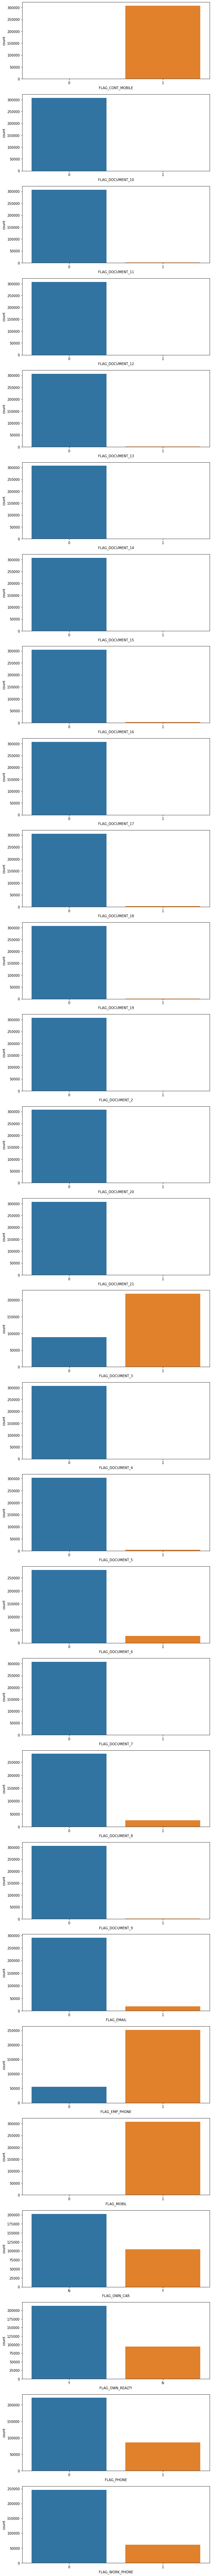

In [23]:
fig, axis = plt.subplots(ncols=1, nrows=len(feat_flags))

fig.set_size_inches(10, 5 * len(feat_flags))

for i in range(len(feat_flags)):
    sns.countplot(x = feat_flags[i], data=data, ax = axis[i])

In [25]:
feat_flags

['FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_EMAIL',
 'FLAG_EMP_PHONE',
 'FLAG_MOBIL',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_PHONE',
 'FLAG_WORK_PHONE']

KeyError: "['FLAG_DOCUMENT_10' 'FLAG_DOCUMENT_11' 'FLAG_DOCUMENT_12'\n 'FLAG_DOCUMENT_13' 'FLAG_DOCUMENT_14' 'FLAG_DOCUMENT_15'\n 'FLAG_DOCUMENT_16' 'FLAG_DOCUMENT_17' 'FLAG_DOCUMENT_18'\n 'FLAG_DOCUMENT_19' 'FLAG_DOCUMENT_2' 'FLAG_DOCUMENT_20'\n 'FLAG_DOCUMENT_21' 'FLAG_DOCUMENT_3' 'FLAG_DOCUMENT_4' 'FLAG_DOCUMENT_5'\n 'FLAG_DOCUMENT_6' 'FLAG_DOCUMENT_7' 'FLAG_DOCUMENT_8' 'FLAG_DOCUMENT_9'] not found in axis"